# What factors influence the price of Airbnb rental most, based on XGBoost and LightGBM machine learning?
 
### Challenge of 3 machine learning prediction models to predict daily rental price

by Dirk Kadijk



# Outline

1. Introduction 
2. Data Assessment and Preparation
3. What month and neighbourhood has the highest daily prices? 
3. What other features are important for daily prices prediction? Feature selection
4. What machine learning model performs better (Random Forest, LGBM, XGBoost)?
6. Conclusions


# 1. Introduction

Pricing short-term rentals are surprisingly complex. Unlike other travel related products like airfare or rental cars, that are offering virtually identical products, there are no two identical rental properties. All rentals are unique due to their location, size, decor, reviews and amenities. Because of the uniqueness of each vacation rental property, one-size fits all pricing schemes fail to properly maximize rental revenue.

Airbnb day prices in Seattle for 2016-2017 are predicted using data analysis and feature engineering. And we apply the machine learning methods [Random Forest regressor](https://en.wikipedia.org/wiki/Random_forest) and the 2 boosting methods [Light Gradient Boosting (LightGBM)](https://lightgbm.readthedocs.io/en/latest/index.html) and [XGBoost regressor](https://en.wikipedia.org/wiki/XGBoost) to see which features in the dataset influence the price the most. 

See section 5 for rationale selecting these 3 popular algoriths and its hyperparameters.



### 1.1. Initial Insights

Before diving deep into data, let's find out some general information on how the reservation price is determined and search for some useful facts for the future analysis.

In our analysis we will concentrate on the factors, which influence the nightly price, determined by the host. Actually, AirBnB already has an algorithm, which suggests hosts the price. The approach for the algorithm and challenges are described in the article __[here](https://www.vrmintel.com/inside-airbnbs-algorithm/)__.
We can also use the information from the article in our analysis:

- Time of the year, when reservation is made, affects the price;
- Amenities offered like Wi-Fi and TV should be considered in the analysis, as they also might have great influence on price;
- It is better to use neighbourhood information rather then exact coordinates to describe the listing location, because sometimes even close locations might have huge difference in listing prices, if they belong to different neighbourhoods or are located different sides of the river. 

### 1.2. Approach

First of all, I chose Seattle dataset, and it will take me the following steps to come into conclusions about factors, affecting reservation prices:

1. First look at the data: 
    * what information we have?; what information is missing?; discover general facts: time period, total number of listings in the dataset
2. Initial data preparation:
    * remove the irrelevant information; reformat the information and imputing missing values  
3. High level analysis:
    * find out high level trends and correlations
4. Use machine learning for further analysis.
    * we train 3 popular models based on decision trees and look at resulting feature importances and model prediction accuracy


The underlying reason and focus for this project is to practice the CRISP-DM process step 'Evaluation - Communicate the business insights' via:
- Create a Github repository to share your code and data wrangling/modeling techniques, with a technical audience in mind
- Create a blog post to share your questions and insights with a non-technical audience. --> A Medium post with a summary of results with the visuals you can find [here](https://medium.com/@dirkkadijk/this-is-how-you-can-save-money-on-an-airbnb-booking-and-predict-prices-with-xgboost-and-lightgbm-8a944e2154eb).





### 1.3. Research questions

What are the main factors, which affect the reservation prices? Does time of the year influence prices and what are the busiest times of the year to visit particular city? 

How important are factors as ratings, amenities and neighbourhood? 

With what accuracy can we predict prices and what is the best machine learning model to use? 





### 1.4. Dataset

Fortunately, we can try to answer these questions by analysing publicly accessible __[AirBnB](https://www.airbnb.com)__ data, available on __[Inside AirBnB](http://insideairbnb.com/get-the-data.html)__ and on __[Kaggle](https://www.kaggle.com/airbnb/seattle)__.

Two data files are downloaded from https://www.kaggle.com/airbnb/seattle.data:
- `listings.csv`: file gives insights about a host, location, review rating score, room and property type. 
- `calendar.csv`: file is about availability and price per each day in 2016-2017 years. Based on 'listing_id' this file will be merged with listings.csv.
- `reviews.csv`: summary review data for the listings. This dataset won't be used in this analysis.

Underlying Jupyter Lab notebook with code is available at https://github.com/dirkkadijk/Airbnb-price-forcasting-via-XGBoost-and-LightGBM.

<br><br>
# 2. Data Wrangling and Preparation

In [1009]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1010]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMModel
import xgboost
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import scipy
from scipy.sparse import hstack

In [1011]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 150)

In [1012]:
df=pd.read_csv("listings.csv")
dfcal=pd.read_csv("calendar.csv")
df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, ...","Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, ...",none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [1013]:
df.shape

(3818, 92)

In [1014]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [1015]:
df.loc[0,:]

id                                                                                                                                                                                 241032
listing_url                                                                                                                                           https://www.airbnb.com/rooms/241032
scrape_id                                                                                                                                                                  20160104002432
last_scraped                                                                                                                                                                   2016-01-04
name                                                                                                                                                         Stylish Queen Anne Apartment
summary                                                               

<br><br>
'Amenities' is in general an important feature. Let's try to create an amenities_length features which gives the # of listed amenities of that listing_id. Datatype of amenities is string, and after a split it become a list of dictionaries (with 0 or n values).

In [1016]:
type(df['amenities'][0])

str

In [1017]:
pd.set_option('display.max_colwidth', 150)
df['amenities'].str.split(',').head(30)

0                             [{TV, "Cable TV", Internet, "Wireless Internet", "Air Conditioning", Kitchen, Heating, "Family/Kid Friendly", Washer, Dryer}]
1     [{TV, Internet, "Wireless Internet", Kitchen, "Free Parking on Premises", "Buzzer/Wireless Intercom", Heating, "Family/Kid Friendly", Washer, Drye...
2     [{TV, "Cable TV", Internet, "Wireless Internet", "Air Conditioning", Kitchen, "Free Parking on Premises", "Pets Allowed", "Pets live on this prope...
3     [{Internet, "Wireless Internet", Kitchen, "Indoor Fireplace", Heating, "Family/Kid Friendly", Washer, Dryer, "Smoke Detector", "Carbon Monoxide De...
4     [{TV, "Cable TV", Internet, "Wireless Internet", Kitchen, Heating, "Family/Kid Friendly", "Smoke Detector", "Carbon Monoxide Detector", "First Aid...
5                                                       [{"Wireless Internet", "Free Parking on Premises", Heating, "Smoke Detector", Essentials, Shampoo}]
6                                      [{"Wireless Internet", "F

In [1018]:
df['amenities'].str.split(',')[0]

['{TV',
 '"Cable TV"',
 'Internet',
 '"Wireless Internet"',
 '"Air Conditioning"',
 'Kitchen',
 'Heating',
 '"Family/Kid Friendly"',
 'Washer',
 'Dryer}']

In [1019]:
len(df['amenities'].str.split(',')[0])

10

In [1020]:
df['amenities_length'] = df['amenities'].str.split(',').apply (lambda x: len(x))           # df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))
df['amenities_length']

0       10
1       16
2       21
3       14
4       13
        ..
3813    16
3814    17
3815    20
3816    11
3817    22
Name: amenities_length, Length: 3818, dtype: int64

In [1021]:
dfcal.head(20)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [1022]:
dfcal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [1023]:
dfcal.date.head(2)

0    2016-01-04
1    2016-01-05
Name: date, dtype: object

In [1024]:
dfcal['month'] = dfcal['date'].apply(lambda x: int(x.split('-')[1]))
dfcal = dfcal.rename(columns={'listing_id': 'id'})
dfcal = dfcal[['id', 'month', 'price']].copy()

In [1025]:
dfcal['price']

0          $85.00
1          $85.00
2             NaN
3             NaN
4             NaN
            ...  
1393565       NaN
1393566       NaN
1393567       NaN
1393568       NaN
1393569       NaN
Name: price, Length: 1393570, dtype: object

In [1026]:
# we can drop the missing data in column 'price' that we are interested in predicting   
dfcal=dfcal.dropna()
dfcal['price']=dfcal['price'].apply(lambda x: float(x[1:].replace(',','')))

In [1027]:
dfcal.head()

,id,month,price
0,241032,1,85.0
1,241032,1,85.0
9,241032,1,85.0
10,241032,1,85.0
14,241032,1,85.0


In [1028]:
dfcal.shape

(934542, 3)

In [1029]:
dfcal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      934542 non-null  int64  
 1   month   934542 non-null  int64  
 2   price   934542 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 28.5 MB


In [1030]:
dfcal.isnull().sum()

id       0
month    0
price    0
dtype: int64

In [1031]:
dfcal.duplicated().sum()

861517

In [1032]:
df['price']

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

In [1033]:
type(df['price'][0])

str

In [1034]:
df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))

In [1035]:
df['price'].head(5)

0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64

In [1036]:
df['extra_people']=df['extra_people'].apply(lambda x: float(x[1:].replace(',','')))

In [1037]:
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: float(str(x).replace('$', '')))

In [1038]:
df.cleaning_fee.value_counts().head(5)

50.0     310
25.0     245
60.0     185
20.0     171
100.0    170
Name: cleaning_fee, dtype: int64

In [1039]:
type(df['cleaning_fee'][1])

numpy.float64

Model evaluation function fits training data, predicts and computes score

In [1040]:
def model_eval(X_train, y_train, X_test, y_test, model):
    '''
    input: X is features data frame, y is response, model
    output: train cross validation score, test score, predicted values
    
    '''
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv = 5)        # Array of R^2 scores of the estimator for each run of the cross validation.
    test_score = r2_score(y_test, y_pred)                                           # R^2 (coefficient of determination) regression score function.            
    return score, test_score, y_pred

def plot_dist(col):
    '''
    plot distribution of feature in column col
    '''
    dfc = df[['id', col]].groupby([col]).count()
    (dfc/df.shape[0]).plot(kind="bar");

def plot_features(X, model, name):
    '''
    plot random forest features importance
    input: dataframe X and regression model
    output: Feature importance plot
    '''
    print("Plot feature importances…")
    headers = ["name", "score"]
    values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)
    features = forest_feature_importances['name'][:25]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:25]
    #plot feature importances
    plt.figure(figsize=(10,5))
    plt.bar(y_pos, scores, align='center', alpha=0.5, color='red')
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances ' + name)
    plt.show()
    

In [1041]:
num_cols = df.shape[0] #Provide the number of columns in the dataset
num_rows = df.shape[1]

In [1042]:
df.cleaning_fee.isnull().sum()

1030

<br><br>Columns with missing values:

In [1043]:
# Provide a set of columns with missing values
nulls = set(df.columns[df.isnull().any()]) 
print(nulls)

{'review_scores_location', 'zipcode', 'medium_url', 'space', 'first_review', 'host_location', 'host_response_rate', 'host_is_superhost', 'host_since', 'host_picture_url', 'xl_picture_url', 'bedrooms', 'last_review', 'host_name', 'reviews_per_month', 'thumbnail_url', 'review_scores_rating', 'neighbourhood', 'host_listings_count', 'review_scores_checkin', 'notes', 'cleaning_fee', 'summary', 'review_scores_cleanliness', 'review_scores_communication', 'host_response_time', 'host_identity_verified', 'host_neighbourhood', 'review_scores_accuracy', 'transit', 'square_feet', 'beds', 'host_has_profile_pic', 'weekly_price', 'host_acceptance_rate', 'neighborhood_overview', 'property_type', 'monthly_price', 'host_about', 'security_deposit', 'bathrooms', 'host_thumbnail_url', 'host_total_listings_count', 'license', 'review_scores_value'}


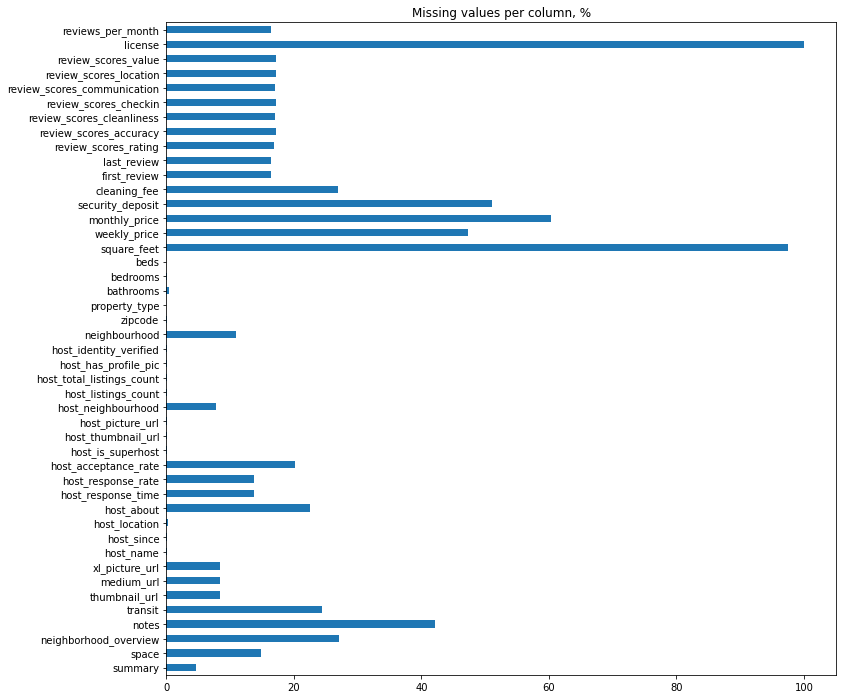

In [1044]:
#find percentage of missing values for each column
listings_missing_df = df.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.barh(title='Missing values per column, %', figsize=(12,12));


Columns with many missing values are: 

In [1045]:
most_missing_cols = set(df.columns[abs(df.isnull().sum()) > 0.7*len(df)])
print(most_missing_cols)
df =df.drop(most_missing_cols, axis=1)

{'square_feet', 'license'}


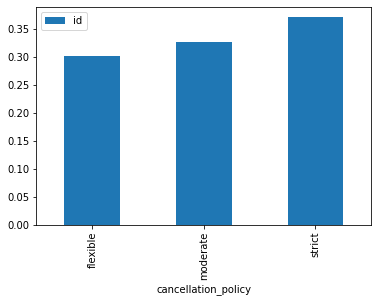

In [1046]:
plot_dist('cancellation_policy')

Check distributions of some features

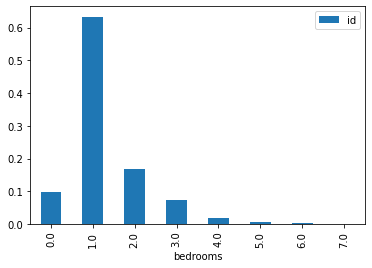

In [1047]:
plot_dist('bedrooms')

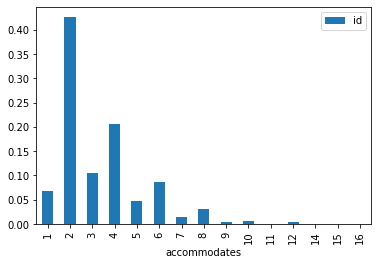

In [1048]:
plot_dist('accommodates')

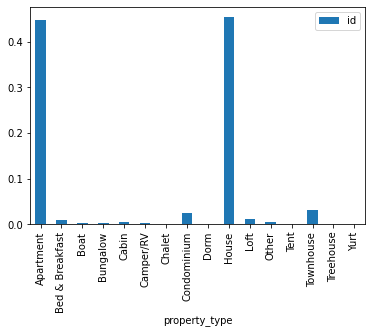

In [1049]:
plot_dist('property_type')

Possible outcome columns related to price

In [1050]:
out=['price', 'weekly_price', 'monthly_price']

In [1051]:
dfm = df.loc[~df['monthly_price'].isnull()]
print(len(dfm))
dfw = df.loc[~df['weekly_price'].isnull()]
print(len(dfw))
print(len(df.loc[~df['price'].isnull()]))

1517
2009
3818


In [1052]:
df.shape

(3818, 91)

### Process numerical features 

In [1053]:
# this feature works better and reduces the number of features
df['totalrooms'] = df['bedrooms'] + df['bathrooms']

In [1054]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x: float(str(x).replace('%', '')))
df['host_since'] = df['host_since'].apply(lambda x:  str(x)[-4:])
col_reviews=['number_of_reviews','review_scores_checkin', 'review_scores_communication', 'reviews_per_month','review_scores_value', 
             'review_scores_rating',  'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']


In [1055]:
type(df['host_since'][0])

str

In [1056]:
# host_listings_count' is also excluded beacause it is almost the same as "host_total_listings_count" and it gives the same result
df= df.drop(columns=['host_listings_count', 'scrape_id', 'host_id'])

In [1057]:
# this feature works better (checked) and reduce number of features
colf = df.select_dtypes(['float', 'int', 'int64']).columns
colf = [i for i in colf if i not in ['id','scrape_id']]
print('The following are the numerical features:\n', colf)

fill_mean = lambda col: col.fillna(int(col.mean()))
# fill the mean
df[colf] = df[colf].apply(fill_mean, axis=0)


The following are the numerical features:
 ['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'amenities_length', 'totalrooms']


In [1058]:
df[col_reviews].isnull().sum()

number_of_reviews              0
review_scores_checkin          0
review_scores_communication    0
reviews_per_month              0
review_scores_value            0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_location         0
dtype: int64

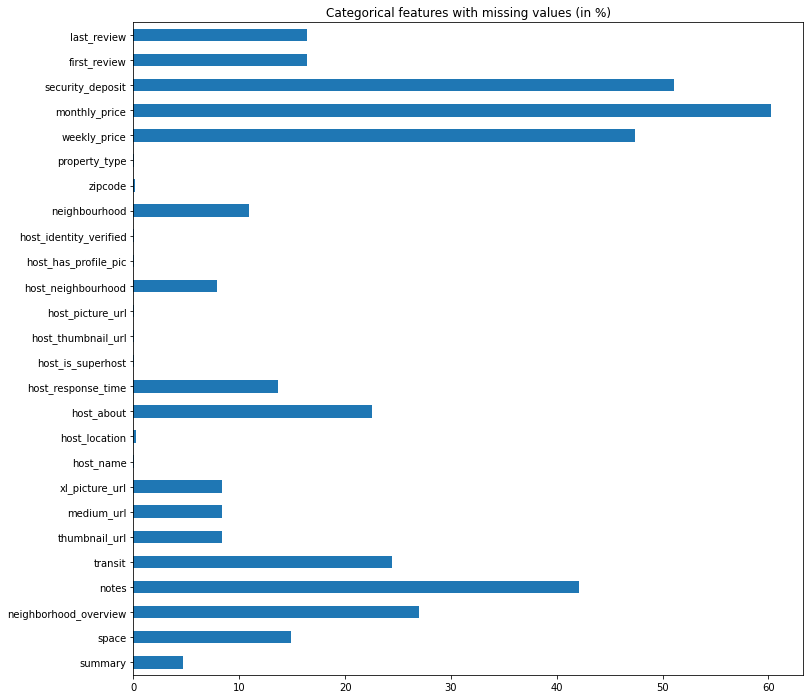

In [1059]:
#find percentage of missing values for each column
listings_missing_df = df.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.barh(title='Categorical features with missing values (in %)', figsize=(12,12));

<br><br>
### Categorical features

In [1060]:
cat_col = df.select_dtypes(include=['object']).columns
df[cat_col] = df[cat_col].fillna('none')
text=['experiences_offered', 'summary', 'amenities', 'name',  'notes', 'description', 'neighborhood_overview', 'transit', 'host_about']
exclude=['id', 'neighbourhood_group_cleansed', 'is_location_exact','host_identity_verified','require_guest_profile_picture', 'require_guest_phone_verification', 
         'security_deposit', 'calendar_last_scraped', 'calendar_updated','host_since','first_review', 'last_review','market','listing_url', 'country', 
         'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 
         'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']

cat_col = [i for i in cat_col if i not in exclude+text]

In [1061]:
df[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_location           3818 non-null   object
 1   host_response_time      3818 non-null   object
 2   host_is_superhost       3818 non-null   object
 3   host_neighbourhood      3818 non-null   object
 4   host_verifications      3818 non-null   object
 5   street                  3818 non-null   object
 6   neighbourhood           3818 non-null   object
 7   neighbourhood_cleansed  3818 non-null   object
 8   zipcode                 3818 non-null   object
 9   smart_location          3818 non-null   object
 10  property_type           3818 non-null   object
 11  room_type               3818 non-null   object
 12  bed_type                3818 non-null   object
 13  weekly_price            3818 non-null   object
 14  monthly_price           3818 non-null   object
 15  has_

<br><br>
# 3. What month and neighbourhood has the highest rent prices? 

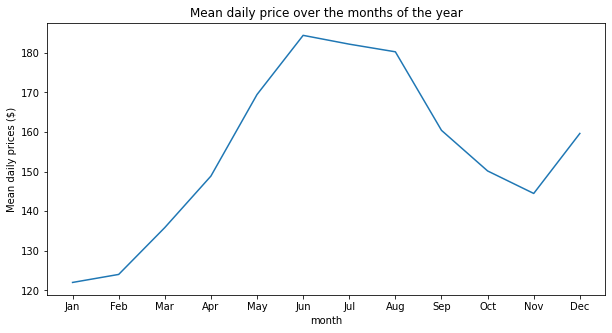

In [1062]:
dfcal = dfcal[['id', 'month', 'price']].drop_duplicates()
average_price_by_month = dfcal[['month', 'price']].groupby('month', as_index=False).mean()
#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month['price'])
plt.ylabel('Mean daily prices ($)')
plt.xticks(np.arange(0, 12, step=1))
plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), rotation=0)
plt.xlabel('month')
plt.title('Mean daily price over the months of the year')

plt.savefig('average price for month')

plt.show()

- In Seattle the highest rental prices are in the summer months June-August. The price change can be noticeable during the year. 

3623


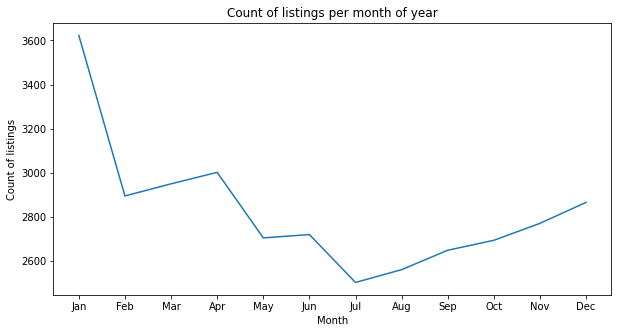

In [1063]:
cp = dfcal[['month', 'id']].drop_duplicates().groupby('month', as_index=False).count()

plt.figure(figsize=(10,5))
plt.plot(cp['id'])

plt.ylabel('Count of listings')

plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), rotation=0)
plt.xlabel('Month')
plt.title('Count of listings per month of year')
print(cp['id'].max())
plt.savefig('count of listings per month')

- The diagram above explains the relative high price in Jun-Aug since there is then a minimum of listings available. So it is beter to visit Seattle and rent cheap and have more choice since there are then lot of listings available.

<br><br>
### Prices Depending on Neighbourhood

We already mentioned above that neighbourhood might have great influence on the listing price. Let's take a look at listing prices depending on neighbourhood.

In [1064]:
df_merged = pd.merge(df, dfcal, on ='id').drop_duplicates()

In [1065]:
dfcal.price[dfcal['price'] == 0.0].count() 

0

In [1066]:
# because of merging of two tables with variables with the same name 'price' we have to rename the column labels:
df_merged = df_merged.rename(columns={"price_x": "day_price", "price_y": "price"})

In [1067]:
#df_merged.info()

In [1068]:
#get list of neighbourhoods
neighbourhoods = df_merged['neighbourhood_group_cleansed'].unique()

#get prices by month and neighbourhood
price_by_month_neighbourhood = df_merged.groupby(['month','neighbourhood_group_cleansed']).mean().reset_index()

In [1069]:
#get list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

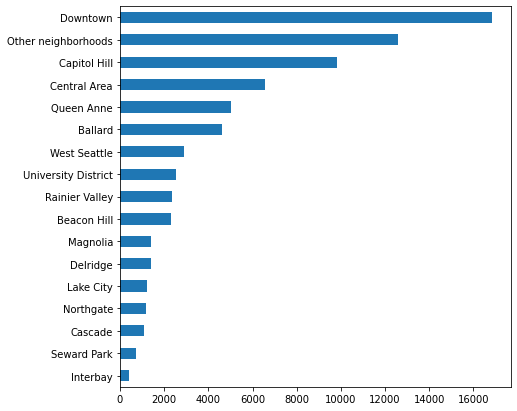

In [1070]:
df_merged.neighbourhood_group_cleansed.value_counts(ascending=True).plot(kind='barh', figsize=(7,7));

- So neighbourhood Downtown has the highest count of (available) listings.

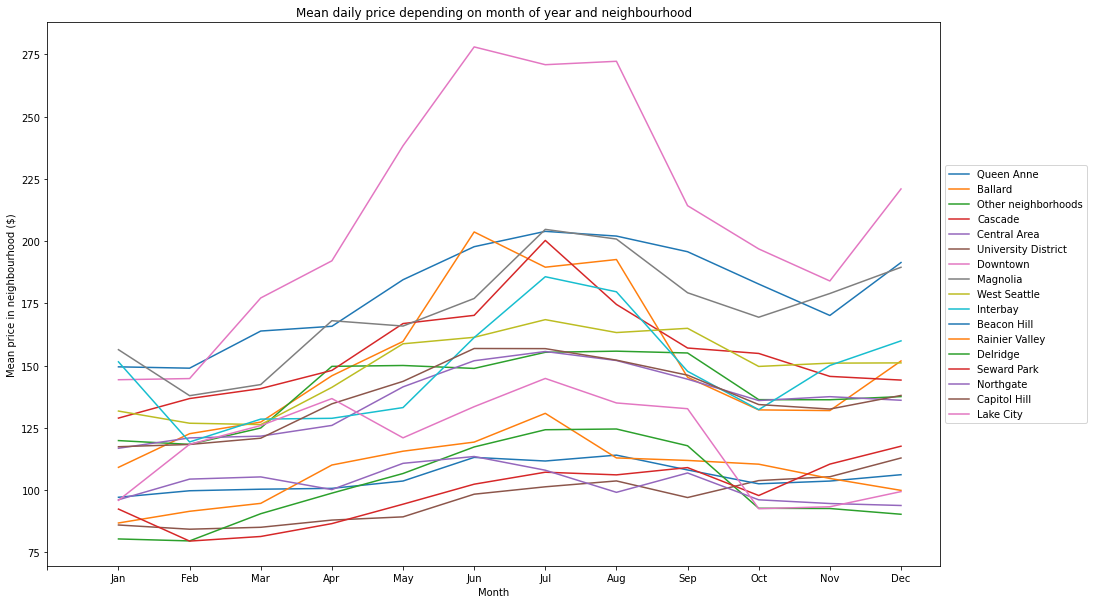

In [1071]:

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Mean price in neighbourhood ($)')
plt.xlabel('Month')

plt.xticks(np.arange(13), ('', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), rotation=0)
plt.title('Mean daily price depending on month of year and neighbourhood')

plt.savefig('images/average price for neighbourhood')
plt.show()


- On the diagram above we can see that the highest average prices are in Seattle Downtown, which is not surprising. But for each neighbourhood prices tend to raise in summer.
Lowest rate is about $ 80 in Jan-Feb-Mar period.

<br><br>
# 4. What other features can be important for daily prices prediction? Feature selection

<br><br>
### Split dataset on train and test before .. merging with calendar data frame to have postings ids splitted.

In [1072]:
del df['price']
df_train, df_test = train_test_split(df, test_size=0.2, random_state=41)  
df_train = pd.merge(df_train, dfcal, on ='id').drop_duplicates()
Y = df_train['price']

In [1073]:
df_train.shape

(57488, 90)

In [1074]:
df_test = pd.merge(df_test, dfcal, on='id').drop_duplicates()
df_test.shape

(15537, 90)

In [1075]:
col = df_train.select_dtypes(['float', 'int', 'int64']).columns

# excluded 'host_listings_count' because it is almost the same as "host_total_listings_count" and it gives the same result. 
# excluded also cleaning_fee because of correlation with dependent variable price
col =[i for i in col if i not in ['id', 'scrape_id', 'cleaning_fee', 'host_listings_count']]

In [1076]:
df_train[col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57488 entries, 0 to 57487
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_response_rate              57488 non-null  float64
 1   host_acceptance_rate            57488 non-null  float64
 2   host_total_listings_count       57488 non-null  float64
 3   latitude                        57488 non-null  float64
 4   longitude                       57488 non-null  float64
 5   accommodates                    57488 non-null  int64  
 6   bathrooms                       57488 non-null  float64
 7   bedrooms                        57488 non-null  float64
 8   beds                            57488 non-null  float64
 9   guests_included                 57488 non-null  int64  
 10  extra_people                    57488 non-null  float64
 11  minimum_nights                  57488 non-null  int64  
 12  maximum_nights                  

<br><br>
#### Heat map to find which (numerical) features are high correlated and may not be be used all together. 


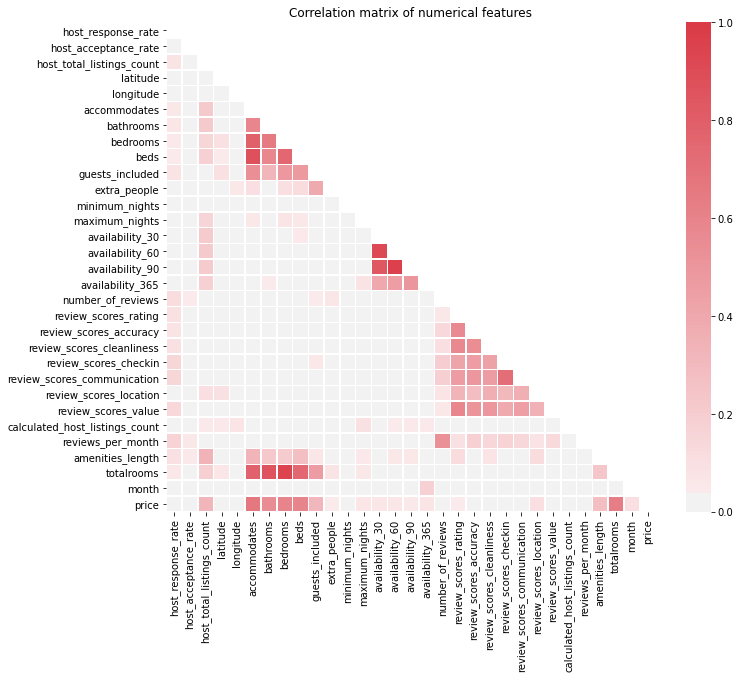

In [1077]:
corr = df_train[col].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=0, vmax=1.0, square=True, linewidths=.5, cbar_kws={"shrink": 1.0});
plt.title('Correlation matrix of numerical features')
plt.savefig('./images/correlations large');

- Above you see 3 'red triangles' with highly correlated features:  
  - the features accommodates, totalrooms (is sum of bathrooms and bedrooms), bathrooms, bedrooms, beds, quests_included have each a high correlation with price;
  - the availability features
  - review_score metrics (accuracy, cleanliness, checkin, communication, location, value) have each a negative correlation with price. Only the review_scores_rating has minor positive correlation with these metrics.  


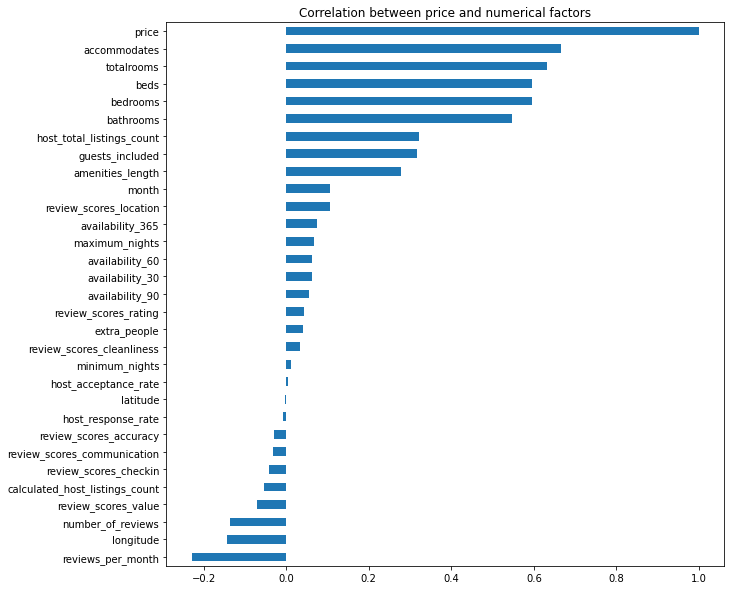

In [1078]:
# we can drop the missing data in column 'price' that we are interested in predicting   
df_train[col].corr() ['price'].sort_values(ascending=True).dropna().plot(kind='barh', figsize=(10,10));
plt.title('Correlation between price and numerical factors');
plt.savefig('./images/correlations price-only');

<br><br>
Let us also check which factors correlate most with review_scores_rating out of curiosity:

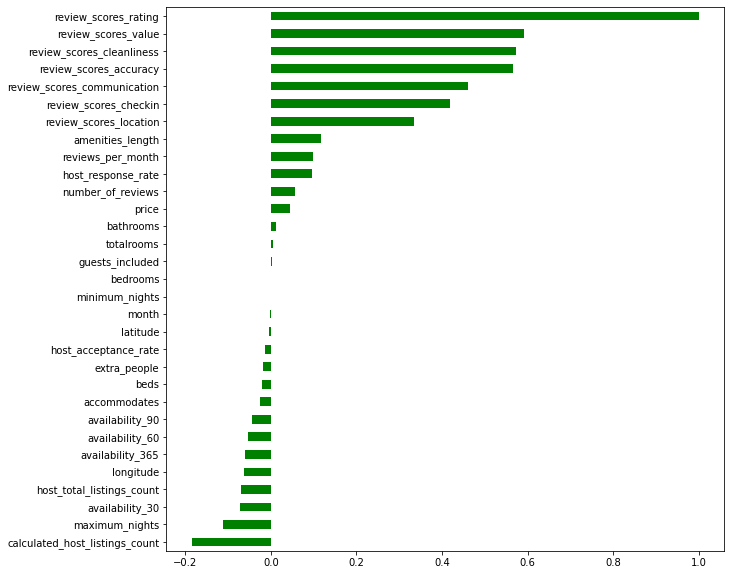

In [1079]:
df_train[col].corr() ['review_scores_rating'].sort_values(ascending=True).dropna().plot(kind='barh', figsize=(10,10), color='green');

<br><br>
# 5. What machine learning model performs better (Random Forest, LightGBM, XGBoost)?

Reasons to use these (popular) 3 algorithms are:
- Random Forest (RF) algorithm: is is not biased, since, there are multiple trees and each tree is trained on a subset of data. Further this algorithm is quite robust: it is stable when adding observations, works well when you have both categorical and numerical features. The RF algorithm also works well when data has missing values or it has not been scaled well.
- XGBoost: because it has gained much popularity and attention recently as the algorithm of choice for many winning teams of machine learning competitions (high accuracy).
- Light GBM: is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.



We compare the performance of the following scenarios:
 1. RF (Random Forest) model - broad set of features
 2. RF model - narrow set of selected features
 3. RF model - with numerical and encoded categorical features together
 4. LGBM model - with numerical and encoded categorical features together
 5. XGBoost model - with numerical and encoded categorical features together



<br><br>
#### 5.1. SCENARIO with Random Forest model - broad set of features 

Tune RF Regressor model to predict price via the hyperparameters:  

>- `n_estimators`  --> The number of trees in the forest )default=100)
>- `criterion` {“mse”, “mae”}, default=”mse”  --> The function to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error.
>- `random_state` (int or RandomState, default=None ) --> Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True)
>- `n_jobs`  --> The number of jobs to run in parallel. -1 means using all processors. 


source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [1080]:
# some columns will be excluded since these price related features are realistically not available when price needs to be forecasted
exc=  ['id', 'price', 'weekly_price', 'monthly_price', 'cleaning_fee']

col = [i for i in col if i not in exc]
print('Number of columns is:', len(col))
print(col)

X_num = df_train[col]
Y = df_train["price"]
Y_test = df_test["price"]
X_test = df_test[col]

model = RandomForestRegressor(n_estimators=100,                
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
score, test_score, y_pred = model_eval(X_num, Y, X_test, Y_test, model)
print('\n')
print('Scenario RF with broad set of selected features:')
print('- Mean of crossvalidation scores:', np.mean(score))
print('- r2_score:', test_score)

Number of columns is: 30
['host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'amenities_length', 'totalrooms', 'month']


Scenario RF with broad set of selected features:
- Mean of crossvalidation scores: 0.6153455850251233
- r2_score: 0.6350827443933018


Plot feature importances…


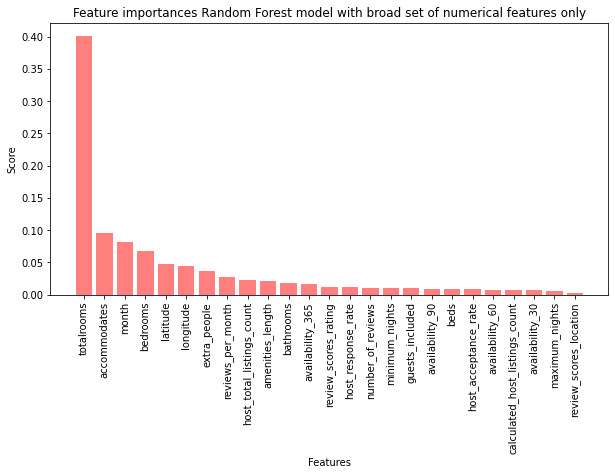

In [1081]:
#ax = lgb.plot_importance(model, max_num_features=28)
#plt.show()
plot_features(X_num, model, "Random Forest model with broad set of numerical features only")

<br><br>
#### 5.2. SCENARIO RF model - narrow set of numerical features selected  (based on correlation matrix and RF feature importance)

In [1082]:
#remove lowest importance values and some of highly correlated, until we have the best result at the end
exc=  ['beds', 'number_of_reviews', 'bathrooms', 'availability_30', 'bedrooms', 'calculated_host_listings_count', 'host_id','maximum_nights', 'host_location' ,'host_acceptance_rate', 
       'calculated_host_listings_count',  'review_scores_checkin', 'price', 'review_scores_value', 'availability_60', 'review_scores_cleanliness', 'review_scores_location', 
       'review_scores_communication', 'review_scores_accuracy',   "price", 'cleaning_fee']

col1 = [i for i in col if i not in exc]
print('Number of columns is:', len(col1))
print(col1)
X_num=df_train[col1]
X_test = df_test[col1]

model_num=RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
score, test_score, y_pred = model_eval(X_num, Y, X_test, Y_test, model_num)
print('\n')
print('Scenario RF with selected features:')
print('- Mean of crossvalidation scores:', np.mean(score))
print('- r2_score:', test_score)

Number of columns is: 15
['host_response_rate', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'guests_included', 'extra_people', 'minimum_nights', 'availability_90', 'availability_365', 'review_scores_rating', 'reviews_per_month', 'amenities_length', 'totalrooms', 'month']


Scenario RF with selected features:
- Mean of crossvalidation scores: 0.6091848867876953
- r2_score: 0.6952400738598872


Plot feature importances…


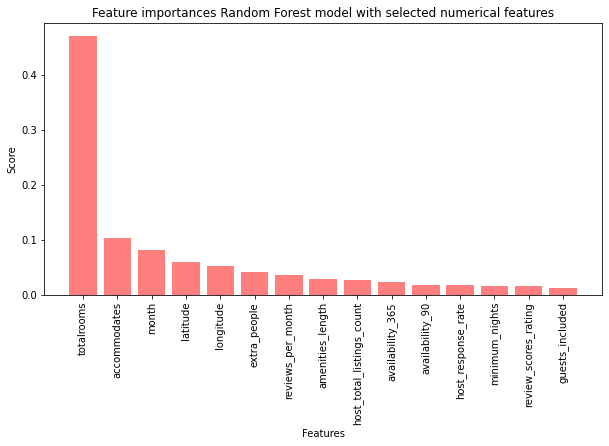

In [1083]:
plot_features(X_num, model_num, "Random Forest model with selected numerical features")

<br><br>
#### 5.3. SCENARIO: RF model - with numerical and encoded categorical features together

<br><br> 
We reject to use LabelEncoding since the categorical features are not ordinal. 

Therefor we will implement sklearn 'One Hot Encoding' without dropping one-hot encoded columns there are several reasons why it's perilous and it is according to [this](https://inmachineswetrust.com/posts/drop-first-columns/) source only required when creating an OLS model with the normal equation.



<br><br>
>NOTE 1: alternative implementation for 'One Hot Encoding' is to use `get_dummies` method which has not been used:

> pd.get_dummies returns a dataframe with encodings based on the values in the dataframe we pass to it. This might be good for a quick analysis, but for an extended model building project where you train on training set and will be later testing on a test set, we can better us sklearn.preprocessing.OneHotEncoder.

>df_train = pd.get_dummies(df_train, columns=['host_response_time', 'host_is_superhost', 'host_neighbourhood', 
                                             'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy'], drop_first=True, dummy_na=False)

<br><br>
>##### NOTE 2: the following code has been used to explore and run an early scenario with `LabelEncoder` implemented; as said this method is rejected:
>le  = LabelEncoder()
for i in cat_col:
    df_train[i] = le.fit_transform(df_train[i].astype('category'))
    df_test[i] = le.fit_transform(df_test[i].astype('category'))
Xtrain_cat = df_train[cat_col]
Xtest_cat = df_test[cat_col]


<br><br>
#### first we 'One Hot Encode' the categorical columns

In [1084]:
# here is dataset with only the selection of most relevant numerical features
df_train_numcol = df_train[col1]
df_train_numcol.head(2)

,host_response_rate,host_total_listings_count,latitude,longitude,accommodates,guests_included,extra_people,minimum_nights,availability_90,availability_365,review_scores_rating,reviews_per_month,amenities_length,totalrooms,month
0,90.0,37.0,47.650211,-122.332035,1,1,0.0,4,90,365,93.0,0.35,13,2.0,1
1,90.0,37.0,47.650211,-122.332035,1,1,0.0,4,90,365,93.0,0.35,13,2.0,2


Let us first explore visually the distribution of some key categorical features:

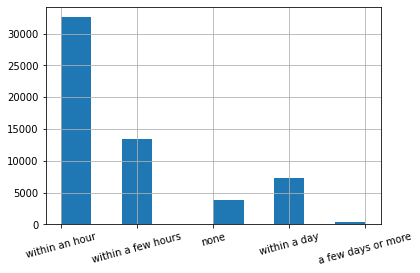

In [1085]:
df_train['host_response_time'].hist(xrot=15);

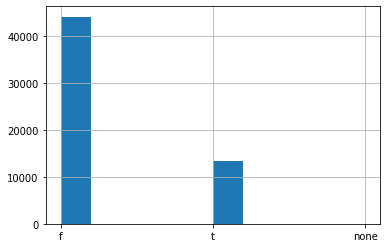

In [1086]:
df_train['host_is_superhost'].hist();

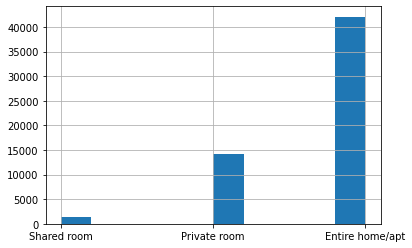

In [1087]:
df_train['room_type'].hist();

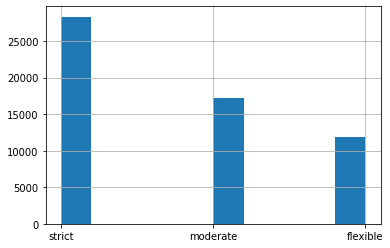

In [1088]:
df_train['cancellation_policy'].hist();

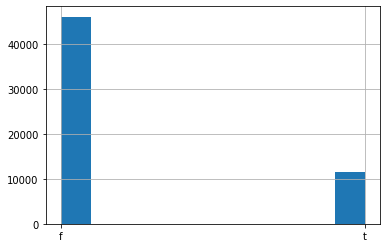

In [1089]:
df_train['instant_bookable'].hist();

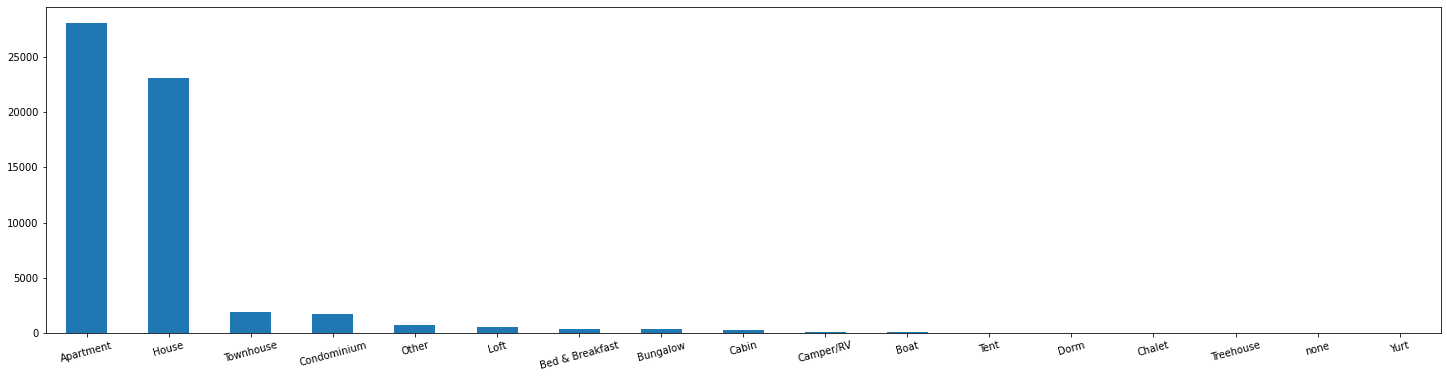

In [1090]:
df_train['property_type'].value_counts().plot(kind='bar', figsize=(25,6), rot=15);

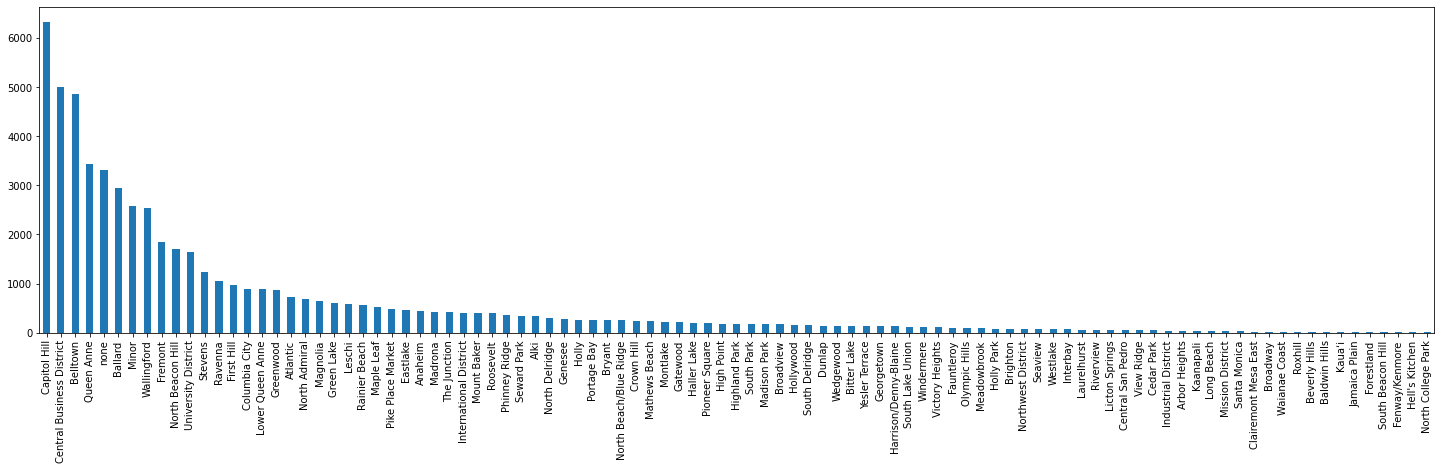

In [1091]:
df_train['host_neighbourhood'].value_counts().plot(kind='bar', figsize=(25,6));

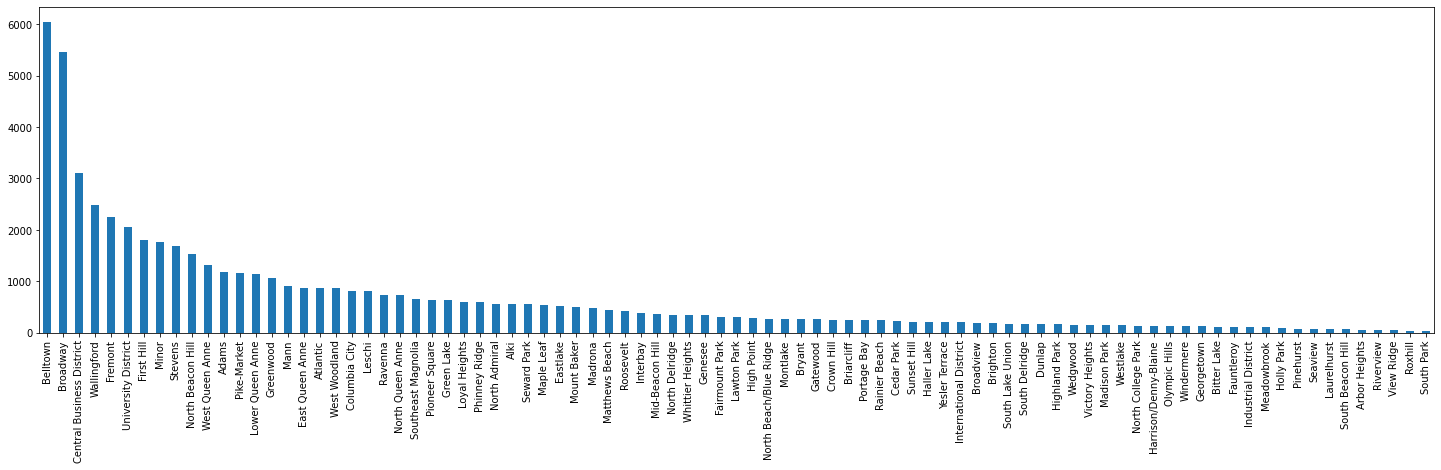

In [1092]:
df_train['neighbourhood_cleansed'].value_counts().plot(kind='bar', figsize=(25,6));

In [1093]:
df_train_numcol.shape

(57488, 15)

In [1094]:
cat_col = ['host_response_time', 'host_is_superhost', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']

In [1095]:
df_train_catcol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57488 entries, 0 to 57487
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_response_time      57488 non-null  object
 1   host_is_superhost       57488 non-null  object
 2   host_neighbourhood      57488 non-null  object
 3   neighbourhood_cleansed  57488 non-null  object
 4   property_type           57488 non-null  object
 5   room_type               57488 non-null  object
 6   cancellation_policy     57488 non-null  object
dtypes: object(7)
memory usage: 6.0+ MB


In [1096]:
df_train_catcol = df_train[cat_col]
df_train_catcol.head(2)

,host_response_time,host_is_superhost,host_neighbourhood,neighbourhood_cleansed,property_type,room_type,cancellation_policy
0,within an hour,f,Capitol Hill,Wallingford,House,Shared room,strict
1,within an hour,f,Capitol Hill,Wallingford,House,Shared room,strict


In [1097]:
df_train_catcol.shape

(57488, 7)

In [1098]:
# One Hot Encoding transform 7 columns to 208 dummy columns
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')                                            # drop='first')  § # handle_unknown='ignore' is redundant with drop='first' 
ohe.fit(df_train_catcol)
df_train_enc = ohe.transform(df_train_catcol)
df_train_enc.shape

(57488, 215)

In [1099]:
type(df_train_enc)

numpy.ndarray

In [1104]:
df_train_enc = pd.DataFrame(df_train_enc)
df_train_enc.head(2)

,0,1,2,3,4,5,6,7,8,9,...,205,206,207,208,209,210,211,212,213,214
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [1105]:
# togther with the 15 numerical features we have 223 columns
df_train_new = pd.merge(df_train_numcol, df_train_enc, left_index=True, right_index=True)
df_train_new.shape

(57488, 230)

#### now we will 'One Hot Encode' the df_test dataframe

In [1106]:
# dataframe with numerical columns only
df_test_numcol = df_test[col1]
# One Hot Encode
df_test_enc = ohe.transform(df_test_catcol)
df_test_enc = pd.DataFrame(df_test_enc.toarray(), columms=ohe.get_feature_names())

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [1107]:
ohe.get_feature_names()

array(['x0_a few days or more', 'x0_none', 'x0_within a day',
       'x0_within a few hours', 'x0_within an hour', 'x1_f', 'x1_none',
       'x1_t', 'x2_Alki', 'x2_Anaheim', 'x2_Arbor Heights', 'x2_Atlantic',
       'x2_Baldwin Hills', 'x2_Ballard', 'x2_Belltown',
       'x2_Beverly Hills', 'x2_Bitter Lake', 'x2_Brighton',
       'x2_Broadview', 'x2_Broadway', 'x2_Bryant', 'x2_Capitol Hill',
       'x2_Cedar Park', 'x2_Central Business District',
       'x2_Central San Pedro', 'x2_Clairemont Mesa East',
       'x2_Columbia City', 'x2_Crown Hill', 'x2_Dunlap', 'x2_Eastlake',
       'x2_Fauntleroy', 'x2_Fenway/Kenmore', 'x2_First Hill',
       'x2_Forestland', 'x2_Fremont', 'x2_Gatewood', 'x2_Genesee',
       'x2_Georgetown', 'x2_Green Lake', 'x2_Greenwood', 'x2_Haller Lake',
       'x2_Harrison/Denny-Blaine', "x2_Hell's Kitchen", 'x2_High Point',
       'x2_Highland Park', 'x2_Holly', 'x2_Holly Park', 'x2_Hollywood',
       'x2_Industrial District', 'x2_Interbay',
       'x2_Internation

In [1001]:
# dataframe with numerical columns only
df_test_numcol = df_test[col1]
# One Hot Encode
df_test_enc = ohe.transform(df_test_catcol)
df_test_enc = pd.DataFrame(df_test_enc)

In [1006]:
df_test_enc

,0,1,2,3,4,5,6,7,8,9,...,205,206,207,208,209,210,211,212,213,214
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15534,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
15535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


- The ValueError abov points out that there are 4 new neighbourhoods. For these unknown categories encountered during the transform, the resulting one-hot encoded columns for this feature will be all zeros.

In [1002]:
df_test_enc.shape

(15537, 215)

In [1003]:
# merge numerical columns with One Hot Encoded columns
df_test_new = pd.merge(df_test_numcol, df_test_enc, left_index=True, right_index=True)
df_test_new.shape

(15537, 230)

In [1004]:
#model
X = df_train_new
X_test = df_test_new

# RF score:
model=RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
#cross_val
score, test_score, y_pred1 = model_eval(X, Y, X_test, Y_test, model)
print('Number of columns is:', df_test_new.shape[1])
print(df_test_new.columns)
print('\n')
print('Scenario Random Forest with numerical and One Hot Encoded categorical features together:')
print('- Mean of crossvalidation scores:', np.mean(score))
print('- r_score:', test_score)


Number of columns is: 230
Index([       'host_response_rate', 'host_total_listings_count',
                        'latitude',                 'longitude',
                    'accommodates',           'guests_included',
                    'extra_people',            'minimum_nights',
                 'availability_90',          'availability_365',
       ...
                               205,                         206,
                               207,                         208,
                               209,                         210,
                               211,                         212,
                               213,                         214],
      dtype='object', length=230)


Scenario Random Forest with numerical and One Hot Encoded categorical features together:
- Mean of crossvalidation scores: 0.6222824876350362
- r_score: 0.7118929930567215


In figure below the feature importance in Random Forest is shown after removing weakest features that improved cross validation test result:

Plot feature importances…


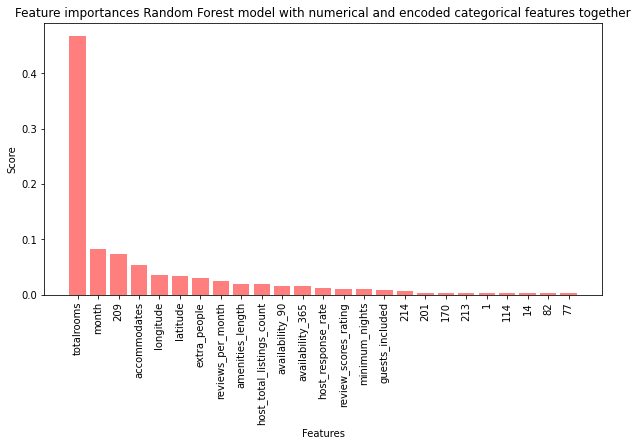

<Figure size 432x288 with 0 Axes>

In [1005]:
plot_features(X, model, "Random Forest model with numerical and encoded categorical features together")
plt.savefig('feature importances RF');

In [902]:
ohe.get_feature_names()

array(['x0_a few days or more', 'x0_none', 'x0_within a day',
       'x0_within a few hours', 'x0_within an hour', 'x1_f', 'x1_none',
       'x1_t', 'x2_Alki', 'x2_Anaheim', 'x2_Arbor Heights', 'x2_Atlantic',
       'x2_Baldwin Hills', 'x2_Ballard', 'x2_Belltown',
       'x2_Beverly Hills', 'x2_Bitter Lake', 'x2_Brighton',
       'x2_Broadview', 'x2_Broadway', 'x2_Bryant', 'x2_Capitol Hill',
       'x2_Cedar Park', 'x2_Central Business District',
       'x2_Central San Pedro', 'x2_Clairemont Mesa East',
       'x2_Columbia City', 'x2_Crown Hill', 'x2_Dunlap', 'x2_Eastlake',
       'x2_Fauntleroy', 'x2_Fenway/Kenmore', 'x2_First Hill',
       'x2_Forestland', 'x2_Fremont', 'x2_Gatewood', 'x2_Genesee',
       'x2_Georgetown', 'x2_Green Lake', 'x2_Greenwood', 'x2_Haller Lake',
       'x2_Harrison/Denny-Blaine', "x2_Hell's Kitchen", 'x2_High Point',
       'x2_Highland Park', 'x2_Holly', 'x2_Holly Park', 'x2_Hollywood',
       'x2_Industrial District', 'x2_Interbay',
       'x2_Internation

<br><br>
#### 5.4. SCENARIO: LGBM model - with numerical and (LabelEncoder)-encoded categorical features together

Tune Light GBM model to predict price via the hyperparameters:  
>- `max_depth`   --> It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.
>- `min_data_in_leaf` --> It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting
>- `boosting_type` --> defines the type of algorithm you want to run, default='gdbt' (gbdt: traditional Gradient Boosting Decision Tree)
>- `learning_rate`--> This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
>- `num_leaves` --> number of leaves in full tree, default: 31

note: more info at https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
##### LGBMRegressor score:

model_lgb = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth =8) 
score, test_score, y_pred_lgbm = model_eval(X, Y, X_test, Y_test, model_lgb)

print('Number of columns is:', df_test_new.shape[1])
print(df_test_new.columns)
print('\n')
print('Scenario LGBM with numerical and encoded categorical features together:')
print('- Mean of crossvalidation scores:', np.mean(score))
print('- r2_score:', test_score)

In figure below the feature importance Light Gradient Boosting is shown after removing weakest features that improved cross validation test result:

In [ ]:
plot_features(X, model_lgb, " LGB model with numerical and encoded categorical features together ")
#plt.savefig('./images/feature importances LGBM');

- The LGBM model above has a broad set of features which are important in the model with as the most dominant: latitude, month, totalrooms, longitude, reviews_per_month, street, amenities_length.

<br><br>
#### 5.5. SCENARIO: XGBoost regressor model - with numerical and (LabelEncoder)-encoded categorical features together

Tune XGBoost Regressor model to predict price via the hyperparameters:  


>- `n_estimators` --> nr of trees
>- `learning_rate` --> Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
>- `gamma`--> Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
>- `subsample` --> Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. Default is 1.
>- `colsample_bytree` --> colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
>- `max_depth` --> Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

source: https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
#train XGBoost model
model_xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

score, test_score, y_pred_xgb = model_eval(X, Y, X_test, Y_test, model_xgb)
#xgb.fit(X_train,y_train)

print('Number of columns is:', df_test_new.shape[1])
print(df_test_new.columns)
print('\n')
print('Scenario XGB with numerical and One Hot Encoded categorical features together:')
print('- Mean of crossvalidation scores:', np.mean(score))
print('- r2_score:', test_score)


<br><br>
Let us now take the average of the the predictions of the LGBM and XGB model to superpose the 2 models:

In [ ]:
plot_features(X, model_xgb, " XGBoost model with numerical and encoded categorical features together")
#plt.savefig('./images/feature importances XGB');

- The XGBoost model above is very much dependent on a small set of dominant features (totalrooms, room_type and accomodates).
<br><br>

Let us check whether a combination of the LGBM and XGB model can create an even better model:

In [ ]:
y_pred_average = 0.5*y_pred_lgbm+0.5*y_pred_xgb
score = r2_score(Y_test, y_pred_average)
print('superposition of models')
print('R2 score is:', score)

- This superposition of the LGBM and XGB models results in a slightly (1%) higher r2_score of 74%.
 

<br><br>
# 6. Conclusions



In this analysis we tried to understand what influences the reservation prices with the help of AirBnB data for Seattle. Of course, the results may be different for each city, but current approach still can be used for other cities' data to determine the price of an Airbnd listing.

The main takeaways of the Seattle data analysis include:

- The Airbnb prices in Seatle depend highly on time of the year and neighbourhood. The highest prices are charged in the summer (Jun-Aug) and the most expensive neighbourhood is Downtown.
- The Light Gradient Boosting (LGBM) model and XGBoost model score a similar accuracy score: R-squared crossvalidation scores of **68%** and r2-score of **72%**. And score a few percent higher than the Random Forest model.
- The advantage of the LGBM model is that it has a broad set of features which are important in the model with as the most dominant: **latitude, month, totalrooms, longitude, reviews_per_month, street, amenities_length.**
- This suggests that the **LGBM model is the more robust model**, however one can use both models and compare (or average) the price forecasts.

The Medium blog with a summary of results with the visuals you can find [here](https://medium.com/@dirkkadijk/this-is-how-you-can-save-money-on-an-airbnb-booking-and-predict-prices-with-xgboost-and-lightgbm-8a944e2154eb).